In [1]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u

# Ipython magics
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


# **Initializing objects:**

In [2]:
True & False

False

In [29]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  t_init + 300
my_dt = 1/24/10 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')
alpha_sirio = 101.28  # right ascension
delta_sirio = -16.7161  # declination
sirio = Source("sirio", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6)
sirio2 = Source("sirio2", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6) #98, -15, 350, -500, -1000, -13.9)
print('Source created')
scanSirio = Scanner(double_telescope=True) 
print('Scanner created')
sirio.reset()
print([sirio.alpha, sirio.delta, sirio.parallax, sirio.mu_alpha_dx, sirio.mu_delta])

Sat created
Source created
Scanner created
[1.767669466419857, -0.29175098309262415, 1.8384619601354712e-06, -6.9464484158848486e-09, -1.6246438518145694e-08]


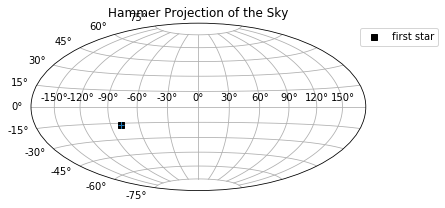

In [30]:
fig = plt.figure()
plt.subplot(111, projection="hammer")
alphas = []
deltas = []

for i, s in enumerate([sirio, sirio2]):
    alpha, delta = s.alpha-np.pi, s.delta
    #print(i, alpha, delta)
    alphas.append(alpha)
    deltas.append(delta)
    if i==0:
        plt.plot(alpha, delta, 'sk', label='first star')
    else:
        plt.plot( alpha, delta,'+')
        pass


plt.title("Hammer Projection of the Sky")
plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True)

# **Scan**

In [31]:
1/24*3

0.125

In [32]:
scanSirio.scan(gaia, sirio, ti=t_init, tf=t_end)
#print('How many wide times?  {}'.format(len(scanSirio.times_wide_scan)))
#print('How many coarse times?  {}'.format(len(scanSirio.times_coarse_scan)))
print('How many observation time?  {}'.format(len(scanSirio.obs_times)))
#print('How many roots?  {}'.format(len(scanSirio.roots)))
# pd.DataFrame(scanSirio.roots)


How many observation time?  33


In [33]:
scanSirio.compute_angles_eta_zeta(gaia, sirio)
scanSirio.eta_scanned

[-8.237854842718662e-14,
 -3.019806626980426e-14,
 -1.1024514634527804e-13,
 7.105427357601002e-15,
 -1.6442402994698568e-13,
 -7.993605777301127e-15,
 -4.1033842990145786e-13,
 -7.073230889886872e-13,
 1.4566126083082054e-13,
 -3.1907809727727e-13,
 -2.1571633368466792e-13,
 -1.2001510896197942e-13,
 2.431388423929093e-13,
 3.312905505481467e-13,
 4.907185768843192e-14,
 4.707345624410664e-14,
 -6.539213615042172e-14,
 1.616484723854228e-13,
 -1.1679546219056647e-13,
 1.8884893648873913e-13,
 6.7390537594747e-13,
 -3.2529534621517087e-13,
 4.107825191113079e-15,
 -4.318767565791859e-14,
 -6.553646514362299e-13,
 -2.55351295663786e-14,
 1.3289369604763124e-13,
 5.752065490582936e-13,
 6.825651155395462e-13,
 6.561418075534675e-14,
 -6.350475700855895e-14,
 -1.6431300764452317e-14,
 -5.1958437552457326e-14]

In [34]:
scanSirio.obs_times_FFoV

[]

In [35]:
scanSirio.obs_times_PFoV

[]

In [36]:
print(scanSirio.scanner_error())
print(np.mean(scanSirio.zeta_scanned))

-6.758903201430119e-15
-0.00027989514547027775


In [37]:
for t in scanSirio.obs_times:
    eta, zeta = observed_field_angles(sirio, gaia.func_attitude(t), gaia, t, True)
    print(eta, zeta)

-8.237854842718662e-14 -0.008153289446040754
-3.019806626980426e-14 -0.005952019441546873
-1.1024514634527804e-13 -0.006838100173053418
7.105427357601002e-15 -0.006487082180801973
-1.6442402994698568e-13 -0.0005727302944872494
-7.993605777301127e-15 0.006427328121394922
-4.1033842990145786e-13 -0.003411182855326637
-7.073230889886872e-13 -0.00783600843942973
1.4566126083082054e-13 0.00050472180764595
-3.1907809727727e-13 -0.005138647445474498
-2.1571633368466792e-13 0.006595096214560406
-1.2001510896197942e-13 0.00831215778276306
2.431388423929093e-13 0.0001691718383856628
3.312905505481467e-13 -0.004160054935750392
4.907185768843192e-14 0.004844529939272298
4.707345624410664e-14 -0.0004065702364678637
-6.539213615042172e-14 0.0006638562675150936
1.616484723854228e-13 -0.007158453524168161
-1.1679546219056647e-13 0.002242549955029846
1.8884893648873913e-13 0.008183400951623952
6.7390537594747e-13 0.00367655388045276
-3.2529534621517087e-13 -0.0005579771027992244
4.107825191113079e-15 0

# **Plots:**

In [38]:
sat = gaia
source = sirio
satellite = gaia 
scan = scanSirio


In [39]:
def get_obs_in_CoMRS(source, sat, t):
        
    attitude = sat.func_attitude(t)
    phi, zeta = observed_field_angles(source, attitude, sat, t, double_telescope=False)  # iven if we have double telescope
    z_axis = np.array([0, 0, 1])
    field_index = np.sign(phi)
    
    eta = field_index * const.Gamma_c / 2
    
    quat1 = Quaternion(vector=z_axis, angle=eta)
    Sx_rot_eta = ft.rotate_by_quaternion(quat1, np.array([1, 0, 0]))
    
    
    vect = np.cross(Sx_rot_eta / np.linalg.norm(Sx_rot_eta), z_axis)
    quat2 = Quaternion(vector=vect, angle=zeta)
    Sx_rot_eta_zeta = ft.rotate_by_quaternion(quat2, Sx_rot_eta)
    
    obs_in_CoMRS = ft.xyz_to_lmn(attitude, Sx_rot_eta_zeta)
    return obs_in_CoMRS

def vector_error(t):
    u_lmn_unit = source.unit_topocentric_function(sat, t)
    vector_error_lmn = u_lmn_unit - sat.func_x_axis_lmn(t)  # Error vector
    vector_error_xyz = ft.lmn_to_xyz(sat.func_attitude(t), vector_error_lmn)
    return vector_error_xyz

def rad_to_mas(angle):
    """:input: angle in rad
       :output: angle in mas"""
    return angle*u.rad.to(u.mas)


In [40]:
print(scanSirio.obs_times)

[89.72603428640231, 89.65207644346918, 267.8709123251708, 41.51339055147932, 268.19487665295, 292.4407786184908, 293.11682271211197, 293.4407889736703, 89.47603593648253, 267.9448729591798, 268.62091829155537, 100.72408806457324, 292.866819971226, 293.19078273790177, 149.52161515394994, 100.47408570249523, 149.59557376158483, 215.01188724956054, 268.3709192890595, 268.69487510642017, 292.61681962666705, 292.94077896371056, 89.40207730458101, 268.1209173243394, 268.44487734464576, 9.549652131467143, 100.6501289397634, 292.36682163332017, 292.6907776056536, 41.58734930313137, 293.3668278946378, 9.623610914484745, 100.40012735498699]


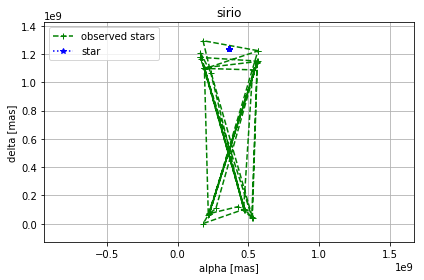

33

In [41]:


alphas_obs, deltas_obs, radius_obs = ([], [], [])
star_alphas, star_deltas, star_radius = ([], [], [])
z_alphas, z_deltas = ([], [])
green_alphas, green_deltas = ([], [])

angle_list = [(star_alphas, star_deltas),
              (alphas_obs, deltas_obs),
              (z_alphas, z_deltas),
              (green_alphas, green_deltas)]

plt.figure()
# for each of the observed times we plot the position of the x-axis in lmn
# of the scanner
for i, t in enumerate(scan.obs_times):

    alpha, delta, radius = ft.vector_to_polar(satellite.func_x_axis_lmn(t))
    alphas_obs.append( rad_to_mas(alpha % (2 * np.pi)))
    deltas_obs.append( rad_to_mas(delta))
    # radius_obs.append(radius)
    # source.set_time(t)
    # star_alphas.append(source.alpha)
    # star_deltas.append(source.delta)
    alpha2, delta2, _, _ = source.topocentric_angles(satellite, t)
    star_alphas.append( rad_to_mas(alpha2))
    star_deltas.append( rad_to_mas(delta2))
    # star_deltas.append(source.radius)

    xaxis = satellite.func_x_axis_lmn(t)
    zaxis = satellite.func_z_axis_lmn(t)
    
    

    vectorz1 = xaxis + np.radians(0.5) * zaxis
    vectorz2 = xaxis - np.radians(0.5) * zaxis

    z_alpha_1, z_delta_1, _ = ft.vector_to_polar(vectorz1)
    z_alpha_2, z_delta_2, _ = ft.vector_to_polar(vectorz2)

    z_alphas.append([rad_to_mas(z_alpha_1), rad_to_mas(z_alpha_2)])
    z_deltas.append([rad_to_mas(z_delta_1), rad_to_mas(z_delta_2)])
    
    # For the observations! ##################################
    xaxis = satellite.func_x_axis_lmn(t)
    zaxis = satellite.func_z_axis_lmn(t)
    # ft.xyz_to_lmn(satellite.func_attitude(t), np.array([1, 0, 0]))
    v_error = vector_error(t)
    vectorz1 = xaxis + v_error[2]*zaxis

    green_alpha, green_delta, _ = ft.vector_to_polar(vectorz1)
    green_alphas.append(rad_to_mas(green_alpha))
    green_deltas.append(rad_to_mas(green_delta))
    # end for observations ###################################
    

for alphas, deltas in angle_list:
    # alphas*u.rad.to(u.mas)
    # deltas*u.rad.to(u.mas)
    pass

# For each couple of ([alpha1,alpha2],[delta1,delta2])
for alpha_delta in zip(z_alphas, z_deltas):
    # plt.plot(alpha_delta[0], alpha_delta[1], 'yo-')
    pass
# plt.plot(alphas_obs, deltas_obs, 'ro--', label='observations')  # plot observation as re dots

plt.plot(green_alphas, green_deltas, 'g+--', label='observed stars')
plt.plot(star_alphas, star_deltas, 'b*:', label='star')  # plot stars as blu stars

plt.legend(loc='upper left'), plt.title('%s' % source.name)
plt.xlabel('alpha [mas]'), plt.ylabel('delta [mas]')
plt.axis('equal'), plt.tight_layout()
plt.margins(0.1), plt.grid()
plt.show()
len(star_alphas)

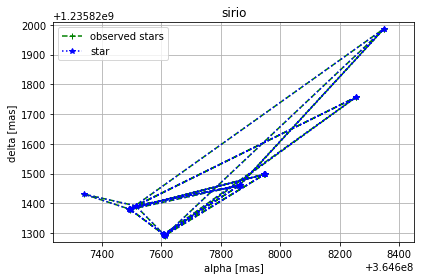

33

In [42]:


alphas_obs, deltas_obs, radius_obs = ([], [], [])
star_alphas, star_deltas, star_radius = ([], [], [])
z_alphas, z_deltas = ([], [])
green_alphas, green_deltas = ([], [])

angle_list = [(star_alphas, star_deltas),
              (alphas_obs, deltas_obs),
              (z_alphas, z_deltas),
              (green_alphas, green_deltas)]

plt.figure()
# for each of the observed times we plot the position of the x-axis in lmn
# of the scanner
for i, t in enumerate(scan.obs_times):

    alpha2, delta2, _, _ = source.topocentric_angles(satellite, t)
    star_alphas.append( rad_to_mas(alpha2))
    star_deltas.append( rad_to_mas(delta2))
    # star_deltas.append(source.radius)
    
    # For the observations! ##################################
    xaxis = satellite.func_x_axis_lmn(t)
    zaxis = satellite.func_z_axis_lmn(t)
    
    """if t in scan.obs_times_PFoV:
        zaxis = satellite.func_z_axis_lmn(t+3/24)
        PFoV = get_PFoV_CoMRS(source, satellite, t)
        v_error = vector_error(t+3/24)"""
    vectorz1 = get_obs_in_CoMRS(source, satellite, t)

    green_alpha, green_delta, _ = ft.vector_to_polar(vectorz1)
    green_alphas.append(rad_to_mas(green_alpha))
    green_deltas.append(rad_to_mas(green_delta))
        
    """if t in scan.obs_times_FFoV:
        zaxis = satellite.func_z_axis_lmn(t+3/24)
        FFoV = get_FFoV_CoMRS(satellite, t)
        v_error = vector_error(t+3/24)
        vectorz1 = FFoV + v_error[2]*zaxis

        green_alpha, green_delta, _ = ft.vector_to_polar(vectorz1)
        green_alphas.append(rad_to_mas(green_alpha))
        green_deltas.append(rad_to_mas(green_delta))"""
    
    # end for observations ###################################
    
    

plt.plot(green_alphas, green_deltas, 'g+--', label='observed stars')
plt.plot(star_alphas, star_deltas, 'b*:', label='star')  # plot stars as blu stars

plt.legend(loc='upper left'), plt.title('%s' % source.name)
plt.xlabel('alpha [mas]'), plt.ylabel('delta [mas]')
plt.axis('equal'), plt.tight_layout()
plt.margins(0.1), plt.grid()
plt.show()
len(star_alphas)

In [43]:
# scanSirio.reset(True)

In [44]:
scanSirio.double_telescope

True

In [45]:
scanSirio.scanner_error()

-6.758903201430119e-15

# **2- Combine with solver:**

In [46]:
my_sirio = Calc_source(scanSirio.obs_times, source=sirio) 

print('real:', my_sirio.s_params)
my_sirio.set_params(my_sirio.s_params + my_sirio.s_params*1e-10)
print('noised:', my_sirio.s_params)
# Solver = Agis(gaia, [my_sirio], [sirio], updating='source', double_telescope=True)

real: [ 1.76766947e+00 -2.91750983e-01  1.83846196e-06 -6.94644842e-09
 -1.62464385e-08]
noised: [ 1.76766947e+00 -2.91750983e-01  1.83846196e-06 -6.94644842e-09
 -1.62464385e-08]


In [47]:
s = np.zeros(5)
sirio.reset()  # resets the source parameters at time t=0
#for i, t_L in enumerate(my_observations):
noise = 0.02 / 1
s[0] =  sirio.alpha + noise
s[1] =  sirio.delta + noise
s[2] =  sirio.parallax - sirio.parallax/ 1000
s[3] =  sirio.mu_alpha_dx + sirio.mu_alpha_dx*0.01
s[4] =  sirio.mu_delta + sirio.mu_delta*0.01

my_sirio = Calc_source('sirio', scanSirio.obs_times, s, sirio.mu_radial) 
Solver = Agis(gaia, [my_sirio], [sirio], updating='scanned source', double_telescope=True)

In [48]:
# Solver.reset_iterations()
Solver.iterate(10)

***** Iteration: 1 *****
Error after iteration: 6.171579174221837e-07
***** Iteration: 2 *****
Error after iteration: 1.168069780604524e-09
***** Iteration: 3 *****
Error after iteration: 2.0714138321577737e-12
***** Iteration: 4 *****
Error after iteration: 3.672329008144314e-15
***** Iteration: 5 *****
Error after iteration: 6.510598006910309e-18
***** Iteration: 6 *****
Error after iteration: 1.154251926694332e-20
***** Iteration: 7 *****
Error after iteration: 2.0464577972285214e-23
***** Iteration: 8 *****
Error after iteration: 3.6257441895952896e-26
***** Iteration: 9 *****
Error after iteration: 6.535663805379192e-29
***** Iteration: 10 *****
Error after iteration: 1.966366170845252e-31


In [49]:
gaia.wz

50.26548245743669

In [50]:
N_aa

NameError: name 'N_aa' is not defined

# **See iterations**

'running'

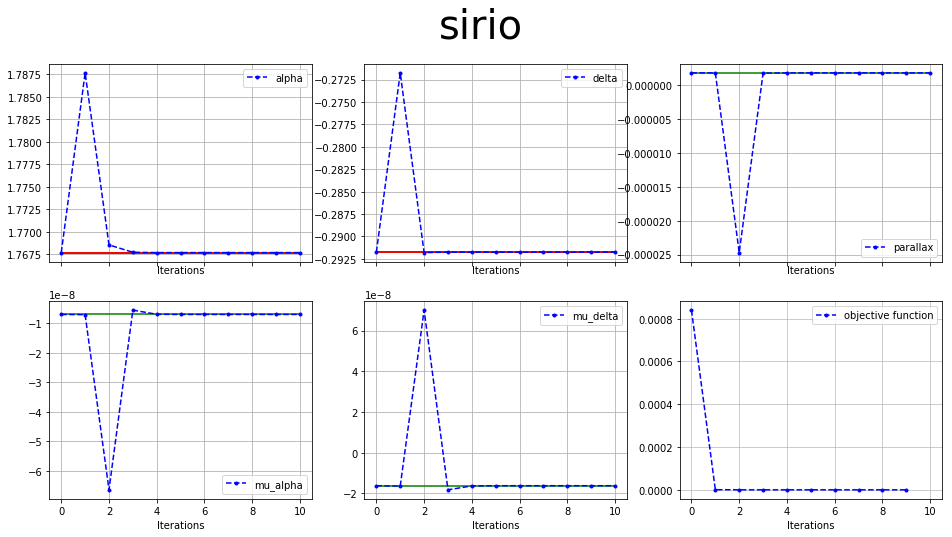

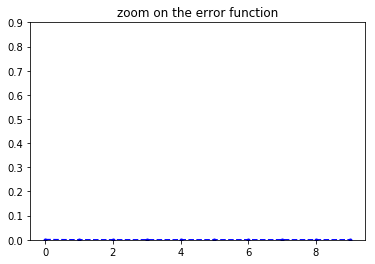

In [51]:
titles = ['sirio']
my_observations = scanSirio.obs_times
for source_index in range(len(Solver.calc_sources)):
    calc_source = Solver.calc_sources[source_index]
    real_source = Solver.real_sources[source_index]
    
    source_params = np.array(calc_source.s_old)
    fig, axs = plt.subplots(2, 3, figsize=(16,8), sharex='all')
    
    fig.suptitle(titles[source_index], fontsize=40)
    
    num_iters = len(calc_source.errors)
    labels = ['alpha', 'delta', 'parallax', 'mu_alpha', 'mu_delta']
    sirio.set_time(0)
    observed = [real_source.alpha, real_source.delta, real_source.parallax, real_source.mu_alpha_dx, real_source.mu_delta]

    alpha_list = []
    delta_list = []
    for t_L in my_observations:
        real_source.set_time(float(t_L))
        alpha_list.append(real_source.alpha)
        delta_list.append(real_source.delta)
    std_alpha = np.std(alpha_list)
    std_delta = np.std(delta_list)
    min_alpha, max_alpha = (np.min(alpha_list), np.max(alpha_list))
    min_delta, max_delta = (np.min(delta_list), np.max(delta_list))

    for i, x in enumerate(source_params.T):
        if i<3:
            ax = axs[0, i]
        else:
            ax = axs[1, i-3]
        ax.plot(x, 'b--.', label=labels[i])
        ax.hlines(observed[i], xmin=0, xmax=num_iters, color='g')
        ax.grid()
        ax.set_label('labels[i]')
        ax.set_xlabel('Iterations')
        ax.legend()

    axs[0,0].hlines(observed[0]+std_alpha, xmin=0, xmax=num_iters, color='g')
    axs[0,0].hlines(observed[0]-std_alpha, xmin=0, xmax=num_iters, color='g')
    axs[0,0].hlines(min_alpha, xmin=0, xmax=num_iters, color='r')
    axs[0,0].hlines(max_alpha, xmin=0, xmax=num_iters, color='r')

    axs[0,1].hlines(observed[1]+std_delta, xmin=0, xmax=num_iters, color='g')
    axs[0,1].hlines(observed[1]-std_delta, xmin=0, xmax=num_iters, color='g')
    axs[0,1].hlines(min_delta, xmin=0, xmax=num_iters, color='r')
    axs[0,1].hlines(max_delta, xmin=0, xmax=num_iters, color='r')

    # plot evolution of the error
    ax = axs[-1, -1] 
    ax.plot(calc_source.errors, 'b--.', label='objective function')
    # ax.set_xlim((0, num_iters))
    ax.set_xlabel('Iterations')
    ax.grid(alpha= 0.8)  
    ax.legend()


    fig.savefig('./figures/tmp/errors')

f3 = plt.figure()
plt.title('zoom on the error function')
plt.plot(calc_source.errors, 'b--.', label='objective function')
plt.ylim((0,0.9))
'running'